In [1]:
import os
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten,BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix

from mpl_toolkits.axes_grid1 import ImageGrid

import itertools

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Import OpenCV
import cv2

from os import listdir
from os.path import isfile, join 

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# https://github.com/abhinav23dixit/Waste-Classification

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

# plot image
# https://www.tensorflow.org/tutorials/images/classification
# https://github.com/msminhas93/KerasImageDatagenTutorial/blob/master/DataGenTutorial.ipynb

# confusion matrix
# https://www.kaggle.com/paoloripamonti/derma-diseases

In [3]:
base_dir = 'Recycling_Data_V1'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
predict_dir = os.path.join(base_dir, 'Predict')

In [4]:
# ResNet50 image size
IMAGE_SIZE = (256,256)
INPUT_SHAPE = (256,256,3)

# Keras settings
TRAIN_BATCH_SIZE = 20
VALDATION_BATCH_SIZE = 20
TEST_BATCH_SIZE = 20

STEPS_PER_EPOCHS = 10
EPOCHS = 5
VALIDATION_STEPS = 228

LEARNING_RATE = 0.0001 

In [5]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TRAIN_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=VALDATION_BATCH_SIZE,
        class_mode='categorical')


# Flow test images in batches of 20 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,  # This is the source directory for training images
        target_size=IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=TEST_BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        shuffle=False)


Found 1297 images belonging to 6 classes.
Found 630 images belonging to 6 classes.
Found 635 images belonging to 6 classes.


In [7]:
# classes training

train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [8]:
class_mapping = {v:k for k,v in train_generator.class_indices.items()}
class_mapping

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [9]:
type(class_mapping)

dict

In [10]:
x,y = next(train_generator) 
y_int = np.argmax(y,axis=-1)

## Plot Methods

In [11]:
def plot(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')
        

def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())
     
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title)    
    plt.show()

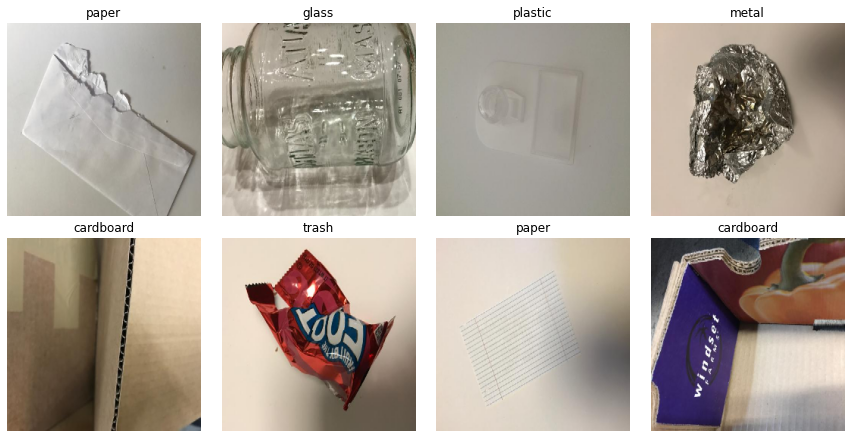

In [12]:
plot(x,2,4,label_list=y_int,show_labels=True,figsize=(15,10))

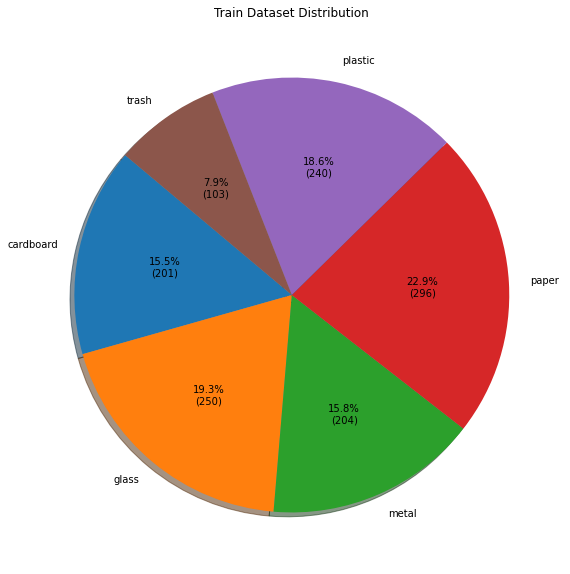

In [13]:
# Train dataset plot
plot_dataset(os.path.join(train_dir), "Train Dataset Distribution")


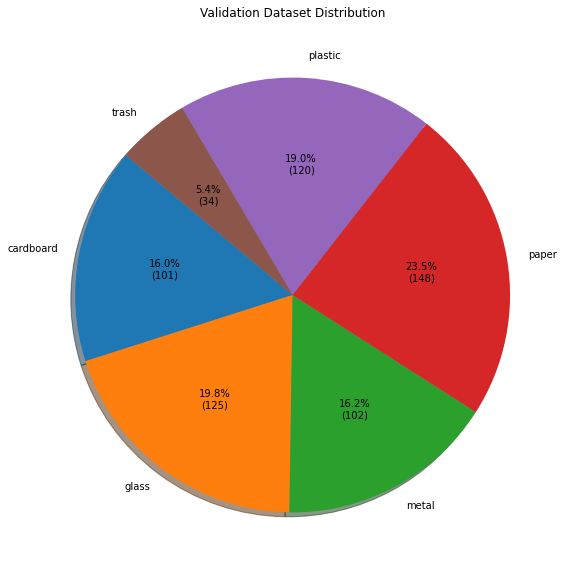

In [14]:
# Validation dataset plot
plot_dataset(os.path.join(validation_dir), "Validation Dataset Distribution")             

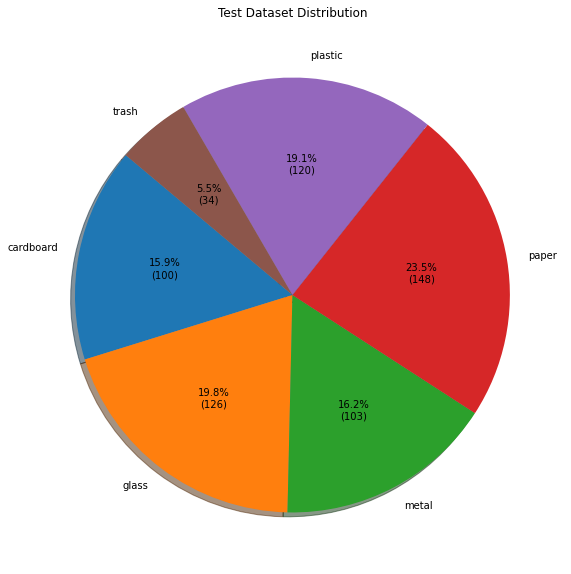

In [15]:
# Test dataset plot
plot_dataset(os.path.join(test_dir), "Test Dataset Distribution")

## Model

In [ ]:
classifier = Sequential()

classifier.add(Convolution2D(input_shape=INPUT_SHAPE,filters=96,kernel_size=(11,11),strides=4,activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(filters=256,kernel_size=(5,5),activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Convolution2D(filters=384,kernel_size=(3,3),activation = 'relu'))
classifier.add(Convolution2D(filters=384,kernel_size=(3,3),activation = 'relu'))
classifier.add(Convolution2D(filters=256,kernel_size=(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
classifier.add(Flatten())

classifier.add(Dense(output_dim=2048,activation='relu'))
classifier.add(Dense(output_dim=2048,activation='relu'))
classifier.add(Dense(output_dim=6,activation='softmax'))

classifier.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
history=classifier.fit_generator(train_generator,
                    steps_per_epoch=STEPS_PER_EPOCHS,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=VALIDATION_STEPS)

In [ ]:
# Performance matrix 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

## Training and Validation dataset performance

In [ ]:
# Graph: Training and Validation dataset performance

plt.rcParams['figure.figsize'] = (12.0, 6.0)

def plot_cnn_performance(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Training accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation accuracy')
    plt.legend()
  

    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and validation categorical crossentropy loss')
    plt.plot(hist['epoch'], hist['loss'],label='Training loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_cnn_performance(history)

In [ ]:
#Evaluate model performance on validation dataset

score = classifier.evaluate_generator(validation_generator)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
#Evaluate model performance on training dataset

score = classifier.evaluate_generator(train_generator)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

In [ ]:
loss, accuracy = classifier.evaluate_generator(test_generator,
            steps=test_generator.samples//test_generator.batch_size)

In [ ]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

In [ ]:
predict=classifier.predict_generator(test_generator)

In [ ]:
y_pred = np.argmax(predict, axis=1)

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
cnf_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [ ]:
plot_confusion_matrix(cnf_matrix, list(class_mapping.values()))

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=list(class_mapping.values())))

## Predict New Images

In [ ]:
def load_image(filename):
    img = cv2.imread(os.path.join(predict_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255    
    return img

def predict(image):
    probabilities = classifier.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)    
    return {class_mapping[class_idx]: probabilities[class_idx]}

In [ ]:
# load image path to predict
onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]

In [ ]:
# load image path to predict
# onlyfiles = [f for f in listdir(predict_dir) if isfile(join(predict_dir, f))]


# for image_file in onlyfiles:
#     print("Image Name - ", image_file);
#     img = load_image(image_file)
#     prediction = predict(img)
#     print("Predicted Class - class: %s, Predicted Confidence: %f" 
#           % (list(prediction.keys())[0], list(prediction.values())[0]))
#     plt.imshow(img)  
#     plt.show()    
    

In [ ]:
classifier.save('model_test_v1.h5')

In [ ]:
# Plot function 

def image_type(filename):
    
    if "glass" in filename:
        return 'glass'
    elif "metal" in filename:
        return 'metal'
    elif "paper" in filename:
        return 'paper'
    elif "plastic" in filename:
        return 'plastic'
    elif "trash" in filename:
        return 'trash'

def plot_predicted_label_1(nrows, ncols,onlyfiles):
    fig, axes = plt.subplots(nrows, ncols,figsize=(20, 20))
    
    rs = np.random.choice(len(onlyfiles), nrows*ncols)
    
    for i, ax in zip(rs, axes.flat):
        img = load_image(onlyfiles[i])
        true_type = image_type(onlyfiles[i])
        prediction = predict(img)
     
        title = 'True: %s, Pred: %s , Confi:%0.2f' % (true_type,list(prediction.keys())[0],list(prediction.values())[0])
        ax.imshow(img, cmap='binary')
        ax.set_title(title)
         
        ax.set_xticks([])
        ax.set_yticks([])
        
# ploat image with predicted and actual value
num_rows = 4
num_cols = 4
plot_predicted_label_1(num_rows, num_cols,onlyfiles);

In [ ]:
import pickle

In [ ]:
model_path =  "../WasteSortingApp/waste_image_classifier.pk"
pickle.dump(classifier, open(model_path,"wb"))